# Imports
Standard Python stack for analysis, modeling, calibration, and monitoring-style diagnostics.


In [1]:
# Imports
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import sparse

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    average_precision_score,
    brier_score_loss,
)
from sklearn.calibration import calibration_curve


# 2) Data checks (risk hygiene)

Before modeling, validate that the dataset is internally consistent and that the target is sensible.

This section covers:
- dataset size, types, and missingness
- base default rate (`loan_status`)
- basic numeric sanity checks (min/max)
- an initial **leakage scan** (features that may encode outcomes or occur post-decision)

> Modeling assumption: all features used later are available at application/decision time (no post-origination variables).


In [2]:
#Load CSV
#csv can be downloaded https://www.kaggle.com/datasets/laotse/credit-risk-dataset
df = pd.read_csv("data/credit_risk_dataset.csv")

#Print shape (rows/cols)

print('Rows & Columns',df.shape)

print( '---------------------------------------' ) 
#Check dtypes for every column.
print(df.dtypes)

#Check missing count per column.
print( '---------------------------------------' ) 
print(df.isnull().sum())

print( '---------------------------------------' ) 
#Check target distribution: y.mean() = bad rate.
print('Average Loans Default',df['loan_status'].mean())


print( '---------------------------------------' ) 
#Quick sanity: min/max for numeric columns
df.select_dtypes(include=["int64", "float64"]).agg(["min", "max"])



Rows & Columns (32581, 12)
---------------------------------------
person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object
---------------------------------------
person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dty

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
min,20,4000,0.0,500,5.42,0,0.00,2
max,144,6000000,123.0,35000,23.22,1,0.83,30


In [3]:
# Data sanity filter: remove implausible values and reset index
df = df.loc[
    (df["person_age"].le(80)) &
    (df["person_emp_length"].le(65))
].reset_index(drop=True)

# Optional: quick check
df[["person_age", "person_emp_length"]].agg(["min", "max", "mean", "median"])


,person_age,person_emp_length
min,20.000000,0.000000
max,80.000000,41.000000
mean,27.726805,4.782271
median,26.000000,4.000000


# 3) Missing data handling

Credit datasets often have missingness that is **informative** (e.g., thin-file behavior).  
I handle missing values inside a preprocessing pipeline to avoid leakage.

Approach:
- numeric: impute (median) + scaling if needed
- categorical: impute (most frequent) + one-hot encoding

> Important: preprocessing is fitted **only on training data** and applied to test/new data via the pipeline.


In [4]:
#List numeric columns (e.g., age, income, emp length, loan amount, int rate, percent income, credit history length).
num_cols = df.select_dtypes(include="number").columns.tolist()
print(num_cols)

#List categorical columns (home ownership, intent, grade, default_on_file).
print( '---------------------------------------' )
cat_cols = df.select_dtypes(include='object').columns.tolist()

print(cat_cols)

['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_status', 'loan_percent_income', 'cb_person_cred_hist_length']
---------------------------------------
['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']


In [5]:
# For numeric missing: inspect only (no pre-split imputation to avoid leakage)

print(df[num_cols].isnull().sum())


person_age                       0
person_income                    0
person_emp_length                0
loan_amnt                        0
loan_int_rate                 3046
loan_status                      0
loan_percent_income              0
cb_person_cred_hist_length       0
dtype: int64


In [6]:
# For categorical missing (if any): inspect only (handled later in the pipeline)

print(df[cat_cols].isnull().sum())


person_home_ownership        0
loan_intent                  0
loan_grade                   0
cb_person_default_on_file    0
dtype: int64


In [7]:
# Confirm missing counts (imputation is applied later via the preprocessing pipeline fit on X_train)

df.isnull().sum()


person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length                0
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3046
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

# 4) Portfolio Overview
Simple

In [8]:
n_loans = len(df)
default_rate = df['loan_status'].mean()

print(f"Total Loans: {n_loans}")
print(f"Default Rate: {default_rate:.2%}")

Total Loans: 31677
Default Rate: 21.55%


# 5) Preprocessing (leakage-safe)

All transformations are implemented in a **single pipeline**:
- consistent transformations between train/test
- prevents data leakage (fit on train only)
- deployable as one object in production

This is the standard approach in regulated modeling environments.


In [9]:
# Split features/target

target = df['loan_status']
features = df.drop(columns='loan_status')



In [10]:

# Train/test split with stratify=y (keeps bad rate consistent).

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42,stratify=target)

In [11]:
# 3. Build a preprocessing pipeline:
# 4.  Numeric: median imputer → (optional) scaler
# 5. Categorical: most_frequent or “Missing” → one-hot encoder


# build cols from FEATURES (not df)
num_cols = features.select_dtypes(include="number").columns.tolist()
cat_cols = features.select_dtypes(include="object").columns.tolist()

num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(transformers=[
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])


In [12]:
#6. Fit preprocessing only on train, transform train and test.

preprocess.fit(X_train)
X_train_prep = preprocess.transform(X_train)
X_test_prep  = preprocess.transform(X_test)

print(X_train_prep.shape, X_test_prep.shape)

(25341, 26) (6336, 26)


# 6) Exploratory analysis (risk-focused)

EDA here is not “pretty plots”; it is used to confirm:
- target makes business sense across key segments
- relationships are directionally plausible
- any features show suspiciously high association with default (potential leakage)
- class imbalance and segmentation patterns that affect policy and monitoring

  loan_grade  default_rate      n
6          G      0.984375     64
5          F      0.703390    236
4          E      0.641807    952
3          D      0.587623   3555
2          C      0.203071   6318
1          B      0.159285  10183
0          A      0.095573  10369


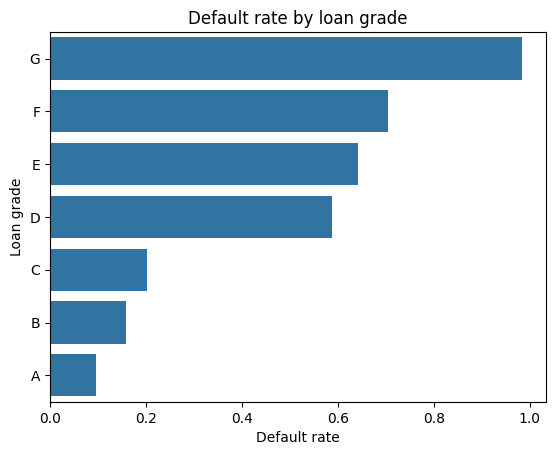


--- Default rate by loan_percent_income bin ---
  lpi_bin  default_rate      n
0   0–10%      0.116156  10219
1  10–20%      0.148416  11771
2  20–30%      0.216481   6019
3  30–40%      0.688147   2607
4  40–50%      0.734223    824
5  50–60%      0.800000    190
6  60–70%      0.789474     38
7  70–80%      0.875000      8
8  80–90%      0.000000      1
9    90%+           NaN      0


/var/folders/0m/gbwrf68d7x1d396vdkq6b3940000gn/T/ipykernel_70670/1632357198.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = (df.groupby(group_col)['loan_status']
/var/folders/0m/gbwrf68d7x1d396vdkq6b3940000gn/T/ipykernel_70670/1632357198.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = (df.groupby(group_col)['loan_status']


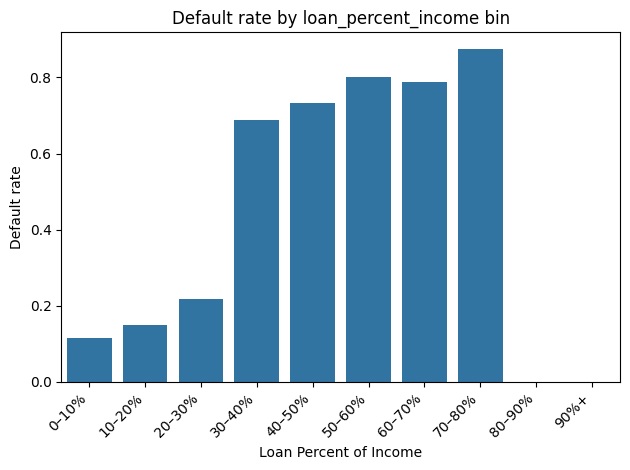


--- Default rate by income_bin ---
  income_bin  default_rate     n
0      0–20k      0.749756  1023
1     20–40k      0.323776  7743
2     40–60k      0.203379  9234
3     60–80k      0.157059  6106
4    80–100k      0.092430  3408
5   100–150k      0.094706  3041
6   150–200k      0.083455   683
7      200k+      0.123007   439


/var/folders/0m/gbwrf68d7x1d396vdkq6b3940000gn/T/ipykernel_70670/1632357198.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = (df.groupby(group_col)['loan_status']
/var/folders/0m/gbwrf68d7x1d396vdkq6b3940000gn/T/ipykernel_70670/1632357198.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = (df.groupby(group_col)['loan_status']


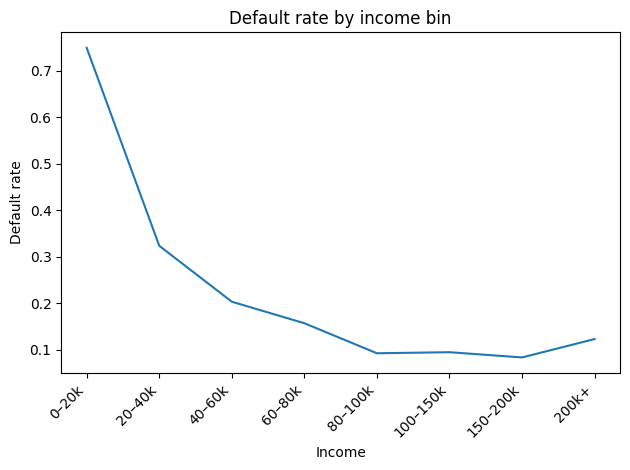

/var/folders/0m/gbwrf68d7x1d396vdkq6b3940000gn/T/ipykernel_70670/1632357198.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = (df.groupby(group_col)['loan_status']



--- Default rate by credit history bin ---
      bin_label  default_rate      n
0  (1.999, 3.0]      0.226431  11562
1    (3.0, 4.0]      0.222647   5749
2    (4.0, 6.0]      0.203506   3651
3    (6.0, 8.0]      0.201887   3710
4   (8.0, 10.0]      0.204183   3634
5  (10.0, 30.0]      0.205577   3371


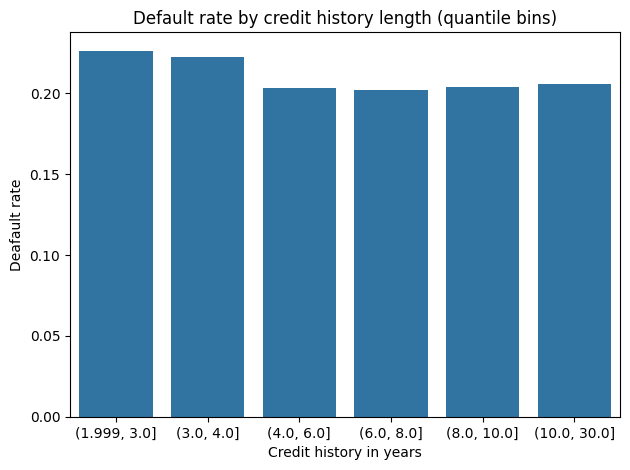

  cb_person_default_on_file  default_rate      n
1                         Y      0.375622   5628
0                         N      0.180851  26049


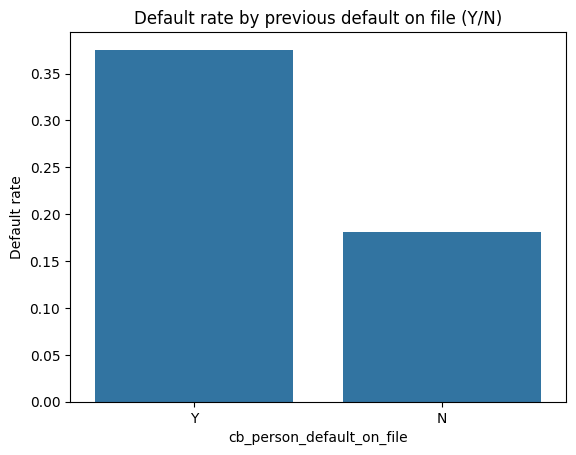

In [13]:
# What’s the default probability for a slice of borrowers?

def default_rate_table(df, group_col):
    out = (df.groupby(group_col)['loan_status']
        .agg(default_rate="mean", n="size")
        .reset_index()
        .sort_values("default_rate", ascending=False))
    return out

tab_grade = default_rate_table(df, "loan_grade")
print(tab_grade)

sns.barplot(data=tab_grade, y="loan_grade", x="default_rate", errorbar=None)
plt.xlabel("Default rate")
plt.ylabel("Loan grade")
plt.title("Default rate by loan grade")
plt.show()


# 2) loan_percent_income: bin into quantiles → default rate per bin

bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, np.inf]
labels = ["0–10%", "10–20%", "20–30%", "30–40%", "40–50%",
        "50–60%", "60–70%", "70–80%", "80–90%", "90%+"]

df["lpi_bin"] = pd.cut(df["loan_percent_income"], bins=bins, labels=labels, include_lowest=True)

tab_lpi = default_rate_table(df, "lpi_bin").sort_values("lpi_bin")
print("\n--- Default rate by loan_percent_income bin ---")
print(tab_lpi)

tab_lpi = default_rate_table(df, "lpi_bin")
sns.barplot(data=tab_lpi, x="lpi_bin", y="default_rate", errorbar=None)
plt.xticks(rotation=45, ha="right")
plt.title("Default rate by loan_percent_income bin")
plt.xlabel("Loan Percent of Income")
plt.ylabel("Default rate")
plt.tight_layout()
plt.show()


# 3) person_income bins (round bins)
bins = [0, 20000, 40000, 60000, 80000, 100000, 150000, 200000, np.inf]
labels = ["0–20k", "20–40k", "40–60k", "60–80k", "80–100k",
        "100–150k", "150–200k", "200k+"]

df["income_bin"] = pd.cut(df["person_income"], bins=bins, labels=labels, include_lowest=True)

tab_inc = default_rate_table(df, "income_bin").sort_values("income_bin")
print("\n--- Default rate by income_bin ---")
print(tab_inc)

tab_inc = default_rate_table(df, "income_bin")
sns.lineplot(data=tab_inc, x="income_bin", y="default_rate", errorbar=None)
plt.xticks(rotation=45, ha="right")
plt.title("Default rate by income bin")
plt.xlabel("Income")
plt.ylabel("Default rate")
plt.tight_layout()
plt.show()

# 4) cb_person_cred_hist_length: bin → default rate
df["cred_hist_bin"] = pd.qcut(df["cb_person_cred_hist_length"], q=8, duplicates="drop")

tab_ch = default_rate_table(df, "cred_hist_bin").sort_values("cred_hist_bin")
tab_ch["bin_label"] = tab_ch["cred_hist_bin"].astype(str)

print("\n--- Default rate by credit history bin ---")
print(tab_ch[["bin_label", "default_rate", "n"]])
sns.barplot(data=tab_ch, x="bin_label", y="default_rate", errorbar=None)
plt.title("Default rate by credit history length (quantile bins)")
plt.xlabel("Credit history in years")
plt.ylabel("Deafault rate")
plt.tight_layout()
plt.show()


# 5) cb_person_default_on_file: default rate by Y/N
tab_file = default_rate_table(df, "cb_person_default_on_file")
print(tab_file)

sns.barplot(data=tab_file, x="cb_person_default_on_file", y="default_rate", errorbar=None)
plt.title("Default rate by previous default on file (Y/N)")
plt.ylabel("Default rate")
plt.show()


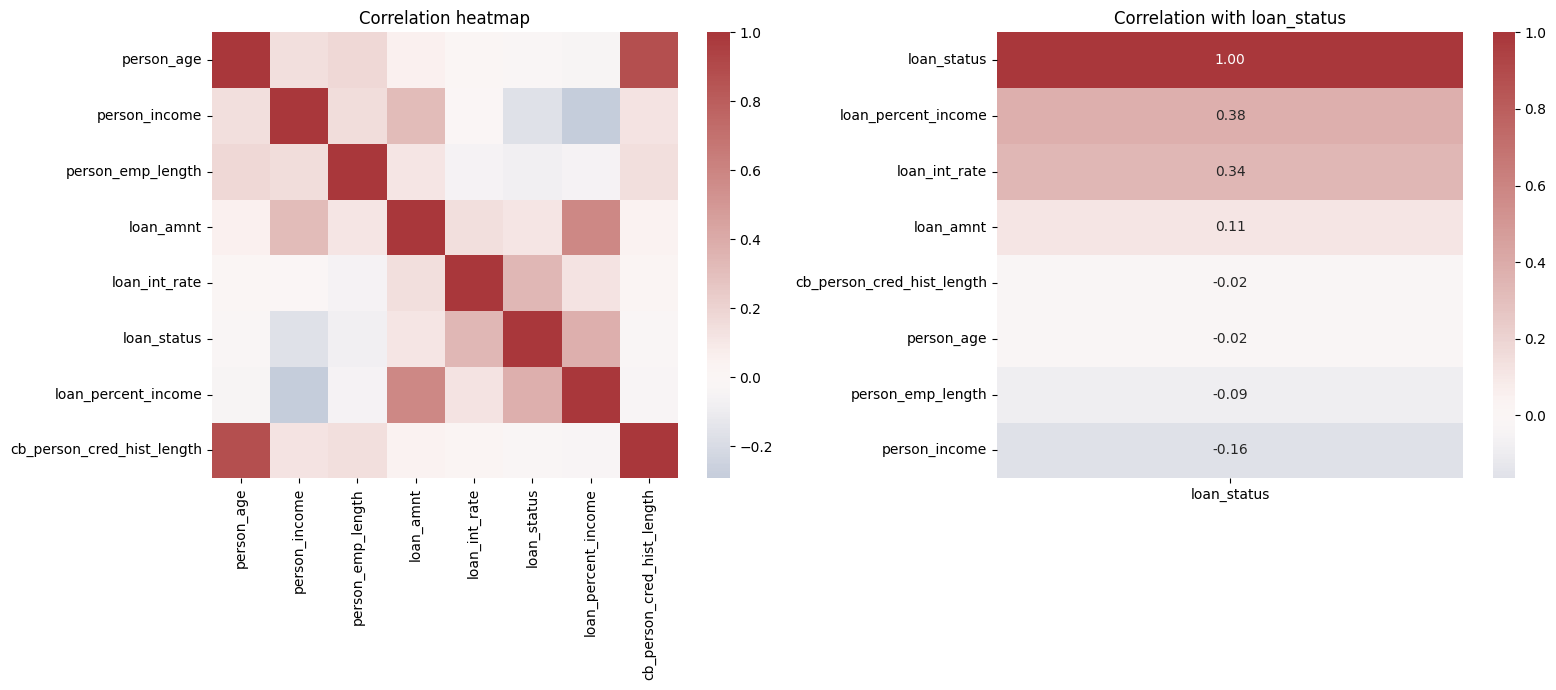

In [14]:
#Heat map correlation between the numeric columns


num_df = df.select_dtypes(include="number")   # dataframe, not list
corr = num_df.corr()
fig, ax = plt.subplots(1, 2, figsize=(16, 7))
corr_target = corr["loan_status"].sort_values(ascending=False)
sns.heatmap(corr, annot=False, cmap="vlag", center=0, ax=ax[0])
ax[0].set_title("Correlation heatmap")

sns.heatmap(corr_target.to_frame(), annot=True, fmt=".2f", cmap="vlag", center=0, ax=ax[1])
ax[1].set_title("Correlation with loan_status")

plt.tight_layout()
plt.show()



# 7) Information Value (IV) screening

IV provides a **univariate** view of predictive signal (commonly used in credit scoring).  
I compute IV on the **training data only** as a screening tool.

Interpretation rule-of-thumb (contextual, not absolute):
- < 0.02: weak
- 0.02–0.1: medium
- 0.1–0.3: strong
- Above 0.3: very strong (also check for leakage / instability)

> IV does not replace multivariate modeling; it helps prioritize variables and sanity-check directionality.


In [15]:


# --- IV function that works for both numeric and categorical features ---
def calculate_iv(df: pd.DataFrame, feature: str, target: str, bins: int = 10) -> float:
    df_temp = df[[feature, target]].copy()

    # Drop missing rows for this feature/target pair
    df_temp = df_temp.dropna(subset=[feature, target])

    # Numeric -> quantile bins; Categorical -> use categories as bins
    if pd.api.types.is_numeric_dtype(df_temp[feature]):
        # If feature has too few unique values, qcut can fail
        if df_temp[feature].nunique() < 2:
            return np.nan
        df_temp["bin"] = pd.qcut(df_temp[feature], q=bins, duplicates="drop")
    else:
        df_temp["bin"] = df_temp[feature].astype("object")

    # IMPORTANT: observed=True silences the FutureWarning and makes behavior explicit
    grouped = df_temp.groupby("bin", observed=True)[target].agg(["count", "sum"])
    grouped.columns = ["total", "bads"]
    grouped["goods"] = grouped["total"] - grouped["bads"]

    # Guard against divide-by-zero (e.g., if a bin has 0 bads or 0 goods overall)
    if grouped["goods"].sum() == 0 or grouped["bads"].sum() == 0:
        return np.nan

    grouped["dist_good"] = grouped["goods"] / grouped["goods"].sum()
    grouped["dist_bad"]  = grouped["bads"] / grouped["bads"].sum()

    # Avoid log(0) by clipping
    eps = 1e-12
    grouped["dist_good"] = grouped["dist_good"].clip(eps, None)
    grouped["dist_bad"]  = grouped["dist_bad"].clip(eps, None)

    grouped["woe"] = np.log(grouped["dist_good"] / grouped["dist_bad"])
    grouped["iv"]  = (grouped["dist_good"] - grouped["dist_bad"]) * grouped["woe"]

    return grouped["iv"].sum()


# --- Compute IV for ALL predictors already in df (no invented column names) ---
target_col = "loan_status"

# Compute IV on TRAINING data only to avoid leakage
train_df = X_train.copy()
train_df[target_col] = y_train

predictor_cols = [c for c in train_df.columns if c != target_col]

iv_rows = []
for col in predictor_cols:
    try:
        iv_val = calculate_iv(train_df, col, target_col, bins=10)
        iv_rows.append({"feature": col, "iv": iv_val})
    except Exception:
        iv_rows.append({"feature": col, "iv": np.nan})

iv_table = (
    pd.DataFrame(iv_rows)
    .dropna(subset=["iv"])
    .sort_values("iv", ascending=False)
    .reset_index(drop=True)
)

iv_table.head(15)


,feature,iv
0,loan_grade,1.058459
1,loan_percent_income,0.873305
2,loan_int_rate,0.739613
3,person_income,0.449760
4,person_home_ownership,0.375761
5,cb_person_default_on_file,0.167632
6,loan_intent,0.103208
7,loan_amnt,0.094143
8,person_emp_length,0.062859
9,person_age,0.010303


# 8) Baseline model: Logistic Regression (benchmark)

Logistic regression is a strong baseline in credit risk:
- interpretable coefficients
- stable behavior
- useful reference point for more flexible models (trees/boosting)

I evaluate ranking (AUC/KS) and calibration (Brier + calibration curve).


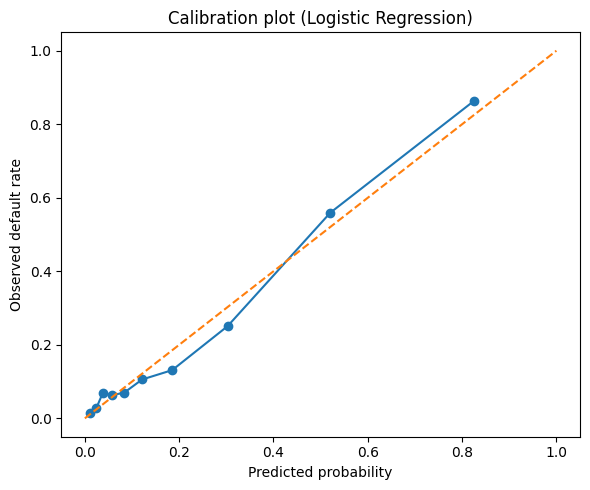

Cutoff chosen (max KS): 0.3008013999268195

Confusion matrix at cutoff:
          Pred 0  Pred 1
Actual 0    4405     566
Actual 1     361    1004

Baseline metrics:
                model   roc_auc        ks    cutoff     brier
0  LogisticRegression  0.874966  0.621671  0.300801  0.098548


In [16]:


# 1) Fit Logistic Regression on processed train data
lr = LogisticRegression(max_iter=5000)
lr.fit(X_train_prep, np.ravel(y_train))   # ravel avoids shape warnings


# 2) Predict probabilities on test
pd_test = lr.predict_proba(X_test_prep)[:, 1]

# 3a) ROC AUC
roc_auc = roc_auc_score(y_test, pd_test)

# 3b) KS statistic (max(TPR - FPR))
fpr, tpr, thr = roc_curve(y_test, pd_test)
ks = np.max(tpr - fpr)

# 3c) Choose cutoff (not only 0.5): pick cutoff that maximizes KS / Youden J
best_idx = np.argmax(tpr - fpr)
cutoff = thr[best_idx]

y_pred = (pd_test >= cutoff).astype(int)
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"])

# 3d) Calibration: Brier + calibration plot
brier = brier_score_loss(y_test, pd_test)

prob_true, prob_pred = calibration_curve(y_test, pd_test, n_bins=10, strategy="quantile")

plt.figure(figsize=(6, 5))
plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("Calibration plot (Logistic Regression)")
plt.xlabel("Predicted probability")
plt.ylabel("Observed default rate")
plt.tight_layout()
plt.show()

# 3e) Save baseline metrics in a small results table
results = pd.DataFrame([{
    "model": "LogisticRegression",
    "roc_auc": roc_auc,
    "ks": ks,
    "cutoff": cutoff,
    "brier": brier
}])

print("Cutoff chosen (max KS):", cutoff)
print("\nConfusion matrix at cutoff:")
print(cm_df)

print("\nBaseline metrics:")
print(results)


In [17]:


def metrics_at_cut(c):
    y_hat = (pd_test >= c).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
    return {
        "cutoff": c,
        "TPR_recall": tp/(tp+fn),
        "FPR": fp/(fp+tn),
        "precision": tp/(tp+fp),
        "approval_rate_pred0": (y_hat==0).mean()
    }

cuts = [0.10, 0.20, 0.2784640044, 0.30, 0.40, 0.50]
pd.DataFrame([metrics_at_cut(c) for c in cuts])


,cutoff,TPR_recall,FPR,precision,approval_rate_pred0
0,0.100000,0.886447,0.394488,0.381583,0.499527
1,0.200000,0.795604,0.203178,0.518130,0.669192
2,0.278464,0.746520,0.129149,0.613486,0.737847
3,0.300000,0.735531,0.113860,0.639490,0.752210
4,0.400000,0.652747,0.069604,0.720291,0.804766
5,0.500000,0.560440,0.044257,0.776650,0.844539


# 9) Challenger models and champion selection

I compare multiple models using:
- **AUC / KS** (ranking power)
- **Brier score + calibration** (quality of PD probabilities)

Champion is chosen to balance:
1) strong ranking performance  
2) usable PD estimates (calibration)  
3) stability (validated via 5-fold stratified CV AUC)


In [18]:


def eval_pd(y_true, pd_test, model_name, n_bins=10):
    # AUC
    auc = roc_auc_score(y_true, pd_test)

    # KS + cutoff (max TPR-FPR)
    fpr, tpr, thr = roc_curve(y_true, pd_test)
    ks = np.max(tpr - fpr)
    best_idx = np.argmax(tpr - fpr)
    cutoff = thr[best_idx]

    # Confusion matrix at cutoff
    y_pred = (pd_test >= cutoff).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calibration / Brier
    brier = brier_score_loss(y_true, pd_test)
    prob_true, prob_pred = calibration_curve(y_true, pd_test, n_bins=n_bins, strategy="quantile")

    metrics = {
        "model": model_name,
        "roc_auc": auc,
        "ks": ks,
        "cutoff": cutoff,
        "brier": brier,
        "TPR_recall": tp/(tp+fn),
        "FPR": fp/(fp+tn),
        "precision": tp/(tp+fp),
        "approval_rate_pred0": (y_pred == 0).mean(),
    }

    cm_df = pd.DataFrame([[tn, fp],[fn, tp]],
                        index=["Actual 0","Actual 1"],
                        columns=["Pred 0","Pred 1"])
    cal_df = pd.DataFrame({"prob_pred": prob_pred, "prob_true": prob_true})
    return metrics, cm_df, cal_df


In [19]:


models = {
    "LogReg": LogisticRegression(max_iter=5000),
    "RandomForest": RandomForestClassifier(
        n_estimators=400, random_state=42, n_jobs=-1,
        max_depth=None, min_samples_leaf=20
    ),
    "HistGB": HistGradientBoostingClassifier(
        random_state=42, max_depth=3, learning_rate=0.1
    ),
    "GradBoost": GradientBoostingClassifier(random_state=42)
}

results = []
conf_mats = {}
cal_curves = {}
pipes = {}

for name, model in models.items():
    pipe_tmp = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", model)
    ])

    pipe_tmp.fit(X_train, np.ravel(y_train))

    # probability of class 1 (default)
    pd_tmp = pipe_tmp.predict_proba(X_test)[:, 1]

    metrics, cm_df, cal_df = eval_pd(y_test, pd_tmp, name)
    results.append(metrics)
    conf_mats[name] = cm_df
    cal_curves[name] = cal_df
    pipes[name] = pipe_tmp

results_df = pd.DataFrame(results).sort_values(["roc_auc", "brier"], ascending=[False, True])

# Set the champion pipeline explicitly (used later for cutoff + stress test)
champ_name = results_df.iloc[0]["model"]
pipe = pipes[champ_name]                       # champion pipeline
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_scores = cross_val_score(
    pipe,
    features, target,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1
)

print("Champion model (for CV):", champ_name)
print("5-fold CV AUC scores:", np.round(auc_scores, 4))
print(f"Mean CV AUC: {auc_scores.mean():.4f}")
print(f"Std CV AUC:  {auc_scores.std():.4f}")

pd_test = pipe.predict_proba(X_test)[:, 1]      # champion PDs on test set

print("Champion model:", champ_name)
results_df


Champion model (for CV): GradBoost
5-fold CV AUC scores: [0.9308 0.9291 0.9256 0.9196 0.9251]
Mean CV AUC: 0.9260
Std CV AUC:  0.0038
Champion model: GradBoost


,model,roc_auc,ks,cutoff,brier,TPR_recall,FPR,precision,approval_rate_pred0
3,GradBoost,0.931814,0.731691,0.418818,0.059986,0.747985,0.016295,0.926497,0.826073
1,RandomForest,0.930275,0.720642,0.372598,0.062157,0.745788,0.025146,0.890639,0.819602
2,HistGB,0.929537,0.724638,0.423561,0.061265,0.739927,0.015289,0.930018,0.828598
0,LogReg,0.874966,0.621671,0.300801,0.098548,0.735531,0.113860,0.639490,0.752210


,feature,importance_mean_auc_drop,importance_std
5,num__loan_percent_income,0.104649,0.001393
1,num__person_income,0.062012,0.002658
10,cat__person_home_ownership_RENT,0.026534,0.001589
20,cat__loan_grade_D,0.021585,0.001463
9,cat__person_home_ownership_OWN,0.016591,0.001830
4,num__loan_int_rate,0.011232,0.001765
13,cat__loan_intent_HOMEIMPROVEMENT,0.007631,0.000759
16,cat__loan_intent_VENTURE,0.005866,0.000970
21,cat__loan_grade_E,0.005213,0.000811
17,cat__loan_grade_A,0.004774,0.001109


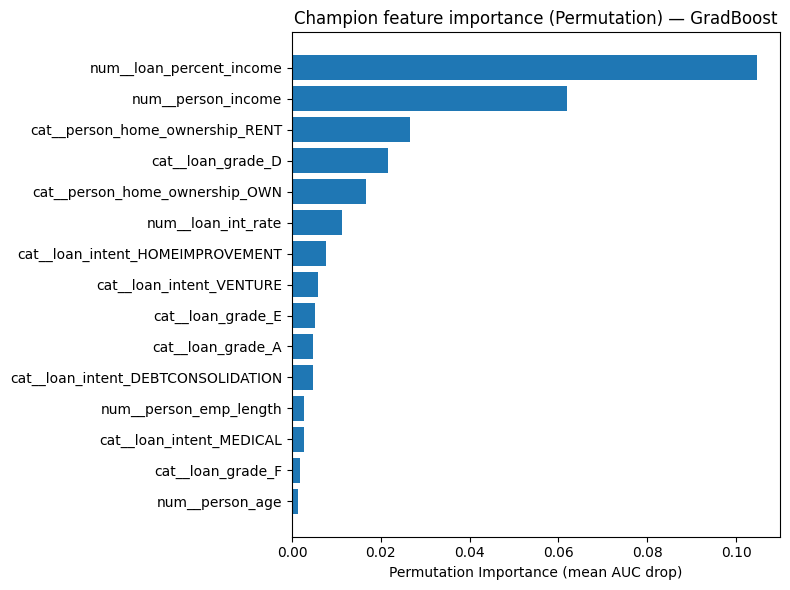

In [20]:



pipe.fit(X_train, np.ravel(y_train))


pre = pipe.named_steps["preprocess"]
feature_names = pre.get_feature_names_out()

X_test_trans = pre.transform(X_test)



model = pipe.named_steps["model"]

perm = permutation_importance(
    model,
    X_test_trans,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring="roc_auc",
    n_jobs=-1
)

imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance_mean_auc_drop": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean_auc_drop", ascending=False)


top_n = 15
display(imp_df.head(top_n))


plt.figure(figsize=(8, 6))
plt.barh(
    imp_df.head(top_n)["feature"][::-1],
    imp_df.head(top_n)["importance_mean_auc_drop"][::-1]
)
plt.xlabel("Permutation Importance (mean AUC drop)")
plt.title(f"Champion feature importance (Permutation) — {champ_name}")
plt.tight_layout()
plt.show()


## Key driver summary (champion: GradBoost)

Permutation importance quantifies how much model ranking performance (**AUC**) decreases when a feature is randomly permuted (higher **mean AUC drop** = more important driver for PD ranking).

### Top drivers (Permutation importance; mean AUC drop)
1) **loan_percent_income** (≈ 0.1047)  
2) **person_income** (≈ 0.0620)  
3) **home_ownership = RENT** (≈ 0.0265)  
4) **loan_grade = D** (≈ 0.0216)  
5) **home_ownership = OWN** (≈ 0.0166)  
6) **loan_int_rate** (≈ 0.0112)  
7) **loan_intent = HOMEIMPROVEMENT** (≈ 0.0076)  
8) **loan_intent = VENTURE** (≈ 0.0059)  
9) **loan_grade = E** (≈ 0.0052)  
10) **loan_grade = A** (≈ 0.0048)

### Interpretation (credit intuition)
- **Affordability / burden dominates**: `loan_percent_income` is the strongest driver, consistent with higher repayment burden increasing default risk.
- **Capacity matters**: higher `person_income` materially improves ranking performance, consistent with stronger ability-to-pay.
- **Housing stability signals risk**: `RENT` is an important risk indicator vs the reference ownership group, while `OWN` also matters (direction is not implied by permutation importance, only predictive contribution).
- **Risk grade / pricing effects**: `loan_grade` levels (D/E/A) and `loan_int_rate` are important, consistent with underwriting/pricing capturing risk differences across borrowers.
- **Intent adds incremental segmentation**: intents such as `HOMEIMPROVEMENT`, `VENTURE`, and `DEBTCONSOLIDATION` contribute additional signal beyond income/burden and grade.

### Concentration check
No single feature fully explains the model: while `loan_percent_income` is the top driver, the importance is distributed across affordability, income, housing, grade, and pricing signals, which is consistent with expected credit risk behavior.


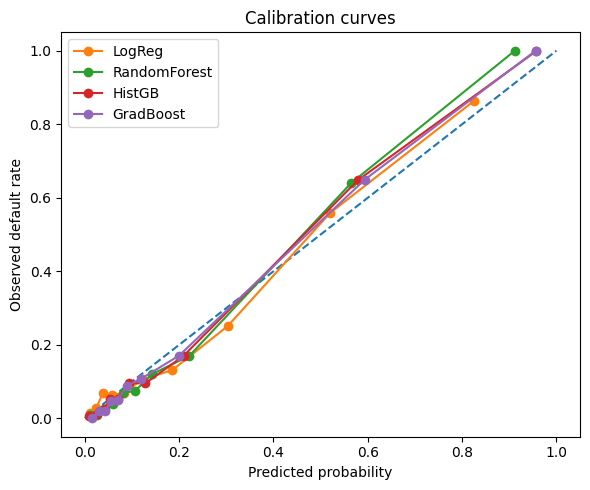

In [21]:
plt.figure(figsize=(6,5))
plt.plot([0,1],[0,1], linestyle="--")

for name, cal_df in cal_curves.items():
    plt.plot(cal_df["prob_pred"], cal_df["prob_true"], marker="o", label=name)

plt.title("Calibration curves")
plt.xlabel("Predicted probability")
plt.ylabel("Observed default rate")
plt.legend()
plt.tight_layout()
plt.show()


In [22]:
# Champion summary + confusion matrix
print("Champion model:", champ_name)
display(conf_mats[champ_name])


Champion model: GradBoost


,Pred 0,Pred 1
Actual 0,4890,81
Actual 1,344,1021


# 10) Interpretability (risk requirement)

A model is only useful in risk if its behavior can be explained to stakeholders.

I provide:
- baseline interpretability: logistic coefficients (direction + magnitude)
- champion interpretability: permutation importance (model-agnostic)

Outputs from this section should support a short narrative:
- top drivers align with credit intuition
- no obviously “illegal” or nonsensical drivers dominate
- results are stable and explainable


In [23]:

try:
    feat_names = preprocess.get_feature_names_out()
except Exception:
    feat_names = []
    for name, trans, cols in preprocess.transformers_:
        if name == "remainder":
            continue
        if hasattr(trans, "get_feature_names_out"):
            feat_names.extend(trans.get_feature_names_out(cols))
        else:
            feat_names.extend(cols)

feat_names = np.array(feat_names)


if lr.coef_.shape[0] != 1:
    raise ValueError(f"Expected binary logistic; got coef_ shape {lr.coef_.shape}")

coefs = lr.coef_[0]


assert len(coefs) == len(feat_names), f"coef length {len(coefs)} != feature length {len(feat_names)}"


coef_df = pd.DataFrame({
    "feature": feat_names,
    "coef": coefs,
    "abs_coef": np.abs(coefs),
    "odds_ratio": np.exp(coefs),
    "direction": np.where(coefs > 0, "increases PD", np.where(coefs < 0, "decreases PD", "no effect")),
}).sort_values("abs_coef", ascending=False)


coef_df["feature_clean"] = (
    coef_df["feature"]
      .str.replace(r"^[^_]+__", "", regex=True)  
      .str.replace("__", "=", regex=False)       
)

top10_logreg = coef_df[["feature_clean", "coef", "odds_ratio", "direction"]].head(10)
top10_logreg


,feature_clean,coef,odds_ratio,direction
23,loan_grade_G,3.098060,22.154920,increases PD
17,loan_grade_A,-2.096880,0.122839,decreases PD
18,loan_grade_B,-1.849496,0.157316,decreases PD
9,person_home_ownership_OWN,-1.756525,0.172644,decreases PD
19,loan_grade_C,-1.620719,0.197756,decreases PD
5,loan_percent_income,1.400394,4.056797,increases PD
22,loan_grade_F,1.035879,2.817583,increases PD
10,person_home_ownership_RENT,0.822385,2.275921,increases PD
21,loan_grade_E,0.696158,2.006032,increases PD
16,loan_intent_VENTURE,-0.695085,0.499032,decreases PD


## Key driver summary (baseline: Logistic Regression)

The logistic regression baseline provides transparent driver directionality via coefficients and odds ratios. Top drivers from the coefficient table:

**Higher PD (risk-increasing)**
- **loan_grade_G** (odds ratio ≈ **22.15**) strongly increases PD relative to the reference grade.
- **loan_percent_income** (odds ratio ≈ **4.06**) increases PD as repayment burden rises.
- **person_home_ownership_RENT** (odds ratio ≈ **2.28**) increases PD vs the reference ownership category.
- **loan_grade_F** (odds ratio ≈ **2.82**) and **loan_grade_E** (odds ratio ≈ **2.01**) increase PD vs the reference grade.

**Lower PD (risk-reducing)**
- **loan_grade_A** (odds ratio ≈ **0.12**), **loan_grade_B** (≈ **0.16**), and **loan_grade_C** (≈ **0.20**) reduce PD vs the reference grade.
- **person_home_ownership_OWN** (odds ratio ≈ **0.17**) reduces PD vs the reference ownership category.
- **loan_intent_VENTURE** (odds ratio ≈ **0.50**) reduces PD vs the reference intent category.

**Credit intuition**
Overall, these drivers are directionally consistent with credit risk expectations:
lower-quality grades and higher payment burden increase default risk; stronger grades and home ownership reduce it.


# 11) Decision policy: PD cutoff and tradeoffs

I convert PD scores into an approval rule: approve if **PD ≤ cutoff**.

For each candidate cutoff I compute:
- approval rate
- bad rate among approved
- bad capture / good retention (optional)
- confusion-matrix style outcomes

I select a cutoff that satisfies a **risk constraint** (e.g., max bad rate among approved) while preserving business volume.


In [24]:
y = np.asarray(y_test).astype(int)
pd_ = np.asarray(pd_test).astype(float)

assert y.shape[0] == pd_.shape[0], "y_test and pd_test must have same length"
assert set(np.unique(y)).issubset({0,1}), "y_test must be binary with 1=bad, 0=good"

# Grid of cutoffs
cutoffs = np.round(np.arange(0.05, 0.501, 0.01), 2)

total_bads = (y == 1).sum()
total_goods = (y == 0).sum()

rows = []
for c in cutoffs:
    approved = pd_ < c
    declined = ~approved

    approval_rate = approved.mean()

    n_approved = approved.sum()
    bads_approved = ((y == 1) & approved).sum()
    bad_rate_among_approved = (bads_approved / n_approved) if n_approved > 0 else np.nan

    # % of bad customers declined (how many defaulters you catch)
    declined_bads = ((y == 1) & declined).sum()
    tpr_bads_caught = (declined_bads / total_bads) if total_bads > 0 else np.nan

    # % of good customers kept (how many non-defaulters you keep)
    approved_goods = ((y == 0) & approved).sum()
    tpr_goods_kept = (approved_goods / total_goods) if total_goods > 0 else np.nan

    rows.append({
        "cutoff": c,
        "approval_rate": approval_rate,
        "bad_rate_among_approved": bad_rate_among_approved,
        "tpr_bads_caught": tpr_bads_caught,
        "tpr_goods_kept": tpr_goods_kept,
        "n_approved": int(n_approved),
    })

cutoff_table = pd.DataFrame(rows)

X = 5.0  

eligible = cutoff_table[
    cutoff_table["bad_rate_among_approved"].notna() &
    (cutoff_table["bad_rate_among_approved"] <= X / 100)
].copy()

if eligible.empty:
    chosen_cutoff = None
    print(f"No cutoff in the grid keeps default rate among approved under {X}%.")
else:
    # Choose highest approval rate (volume). Tie-breaker: lower cutoff is more conservative.
    chosen = eligible.sort_values(["approval_rate", "cutoff"], ascending=[False, True]).iloc[0]
    chosen_cutoff = float(chosen["cutoff"])
    print(f"Chosen cutoff (PD threshold) to keep default rate under {X}%: {chosen_cutoff:.2f}")

# Nice % view (business-friendly)
cutoff_table_view = cutoff_table.copy()
for col in ["approval_rate", "bad_rate_among_approved", "tpr_bads_caught", "tpr_goods_kept"]:
    cutoff_table_view[col] = (100 * cutoff_table_view[col]).round(2)

cutoff_table_view.rename(columns={
    "cutoff": "Risk threshold (PD limit)",
    "approval_rate": "% Approved",
    "bad_rate_among_approved": "% of approved customers who default",
    "tpr_bads_caught": "% of bad customers declined",
    "tpr_goods_kept": "% of good customers kept",
    "n_approved": "Total Approved",
}, inplace=True)

if chosen_cutoff is not None:
    display(cutoff_table_view[cutoff_table_view["Risk threshold (PD limit)"] == chosen_cutoff])

cutoff_table_view


Chosen cutoff (PD threshold) to keep default rate under 5.0%: 0.15


,Risk threshold (PD limit),% Approved,% of approved customers who default,% of bad customers declined,% of good customers kept,Total Approved
10,0.15,71.1,4.93,83.74,86.16,4505


,Risk threshold (PD limit),% Approved,% of approved customers who default,% of bad customers declined,% of good customers kept,Total Approved
0,0.05,30.79,1.38,98.02,38.70,1951
1,0.06,38.89,1.99,96.41,48.58,2464
2,0.07,45.20,2.51,94.73,56.17,2864
3,0.08,50.16,2.77,93.55,62.16,3178
4,0.09,55.51,3.18,91.79,68.50,3517
5,0.10,59.85,3.80,89.45,73.39,3792
6,0.11,62.82,3.99,88.35,76.87,3980
7,0.12,65.45,4.17,87.33,79.94,4147
8,0.13,67.77,4.45,86.01,82.54,4294
9,0.14,69.49,4.79,84.54,84.33,4403


# 12) Stress testing (scenario sensitivity)

Purpose: understand how portfolio approvals and risk metrics change under adverse conditions.

Scenarios are implemented as **feature shocks** (e.g., income down, rates up) while holding the policy constant.

Interpretation note:
- If approvals drop materially, the approved pool can become more selective, which may reduce observed bad rate among approved (selection effect).


In [25]:


cutoff = chosen_cutoff if (("chosen_cutoff" in globals()) and (chosen_cutoff is not None)) else 0.15
y = np.asarray(y_test).astype(int)


X_base = X_test.copy()
if not isinstance(X_base, pd.DataFrame):
    X_base = pd.DataFrame(X_base)


required_cols = ["loan_int_rate", "person_income"]
missing = [c for c in required_cols if c not in X_base.columns]
if missing:
    raise ValueError(f"X_test is missing required columns for stress test: {missing}")

def policy_metrics(pd_vec, y_true, cutoff):
    approved = pd_vec < cutoff
    approval_rate = approved.mean()

    n_approved = approved.sum()
    bads_approved = ((y_true == 1) & approved).sum()
    bad_rate = (bads_approved / n_approved) if n_approved > 0 else np.nan

    return {
        "avg_PD": float(np.mean(pd_vec)),
        "approval_rate": float(approval_rate),
        "bad_rate_among_approved": float(bad_rate),
        "n_approved": int(n_approved),
    }


pd_base = pipe.predict_proba(X_base)[:, 1]

#senario A
X_A = X_base.copy(deep=True)
rate_med = np.nanmedian(pd.to_numeric(X_A["loan_int_rate"], errors="coerce"))
rate_shock = 0.02 if rate_med <= 1.0 else 2.0
X_A["loan_int_rate"] = pd.to_numeric(X_A["loan_int_rate"], errors="coerce") + rate_shock
pd_A = pipe.predict_proba(X_A)[:, 1]

#senario B
X_B = X_base.copy(deep=True)
X_B["person_income"] = pd.to_numeric(X_B["person_income"], errors="coerce") * 0.90
pd_B = pipe.predict_proba(X_B)[:, 1]

m_base = policy_metrics(pd_base, y, cutoff)
m_A    = policy_metrics(pd_A,    y, cutoff)
m_B    = policy_metrics(pd_B,    y, cutoff)

report = pd.DataFrame([
    {"scenario": "Baseline", **m_base},
    {"scenario": f"Scenario A: loan_int_rate +{rate_shock} ({'decimal' if rate_shock==0.02 else 'pp'})", **m_A},
    {"scenario": "Scenario B: person_income -10%", **m_B},
])

for col in ["avg_PD", "approval_rate", "bad_rate_among_approved"]:
    report[f"delta_{col}"] = report[col] - report.loc[0, col]

report_view = report.copy()
pct_cols = ["avg_PD", "approval_rate", "bad_rate_among_approved",
            "delta_avg_PD", "delta_approval_rate", "delta_bad_rate_among_approved"]
for c in pct_cols:
    report_view[c] = (100 * report_view[c]).round(2)

report_view.rename(columns={
    "avg_PD": "Average PD (%)",
    "approval_rate": "% Approved",
    "bad_rate_among_approved": "% of approved customers who default (approx)",
    "delta_avg_PD": "Change in avg PD (pp)",
    "delta_approval_rate": "Change in approval rate (pp)",
    "delta_bad_rate_among_approved": "Change in default rate among approved (pp)",
    "n_approved": "Number approved",
}, inplace=True)

print(f"Policy cutoff used for stress test: PD < {cutoff:.2f} is approved")
report_view[[
    "scenario",
    "Average PD (%)", "Change in avg PD (pp)",
    "% Approved", "Change in approval rate (pp)",
    "% of approved customers who default (approx)", "Change in default rate among approved (pp)",
    "Number approved"
]]


Policy cutoff used for stress test: PD < 0.15 is approved


,scenario,Average PD (%),Change in avg PD (pp),% Approved,Change in approval rate (pp),% of approved customers who default (approx),Change in default rate among approved (pp),Number approved
0,Baseline,21.73,0.00,71.10,0.00,4.93,0.00,4505
1,Scenario A: loan_int_rate +2.0 (pp),23.89,2.16,62.34,-8.76,4.20,-0.73,3950
2,Scenario B: person_income -10%,22.82,1.09,69.14,-1.96,4.82,-0.11,4381


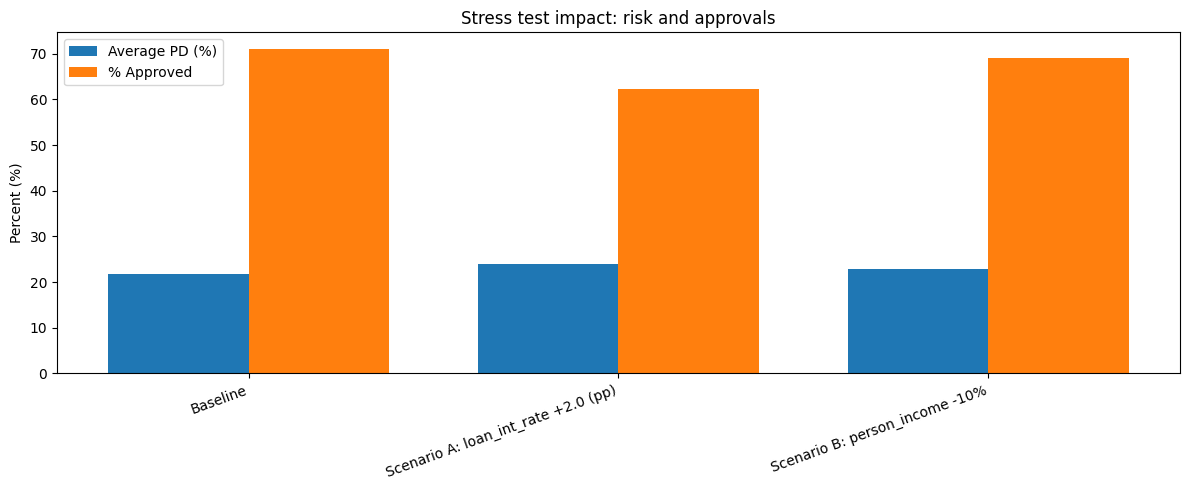

In [26]:

scenarios = report_view["scenario"].values
avg_pd = report_view["Average PD (%)"].astype(float).values
approved = report_view["% Approved"].astype(float).values

x = np.arange(len(scenarios))
width = 0.38

plt.figure(figsize=(12, 5))
plt.bar(x - width/2, avg_pd, width, label="Average PD (%)")
plt.bar(x + width/2, approved, width, label="% Approved")
plt.xticks(x, scenarios, rotation=20, ha="right")
plt.ylabel("Percent (%)")
plt.title("Stress test impact: risk and approvals")
plt.legend()
plt.tight_layout()
plt.show()


# 13) Profit / loss simulation (business framing)

To connect the cutoff decision to business outcomes, I simulate an expected value framework.

Assumptions (illustrative):
- Approving a good loan yields profit **+P**
- Approving a bad loan yields loss **-L**
- Rejecting yields 0

I evaluate expected value across cutoffs and can choose:
- max expected value subject to risk constraints, or
- a cutoff that meets a target approval rate / default constraint.


In [27]:

# ---- REQUIRED existing objects ----
# y_test: true labels for test
# y_pred_prob: predicted PD for test (probability of bad = 1)
# If your variable is named differently, change y_pred_prob below.

# Simple value model (adjust numbers if you want)
profit_good = 1     # profit for approving a good loan (actual=0)
loss_bad = -5       # loss for approving a bad loan (actual=1)

thresholds = np.linspace(0.01, 0.99, 99)
rows = []

y_true = np.array(y_test)

for t in thresholds:
    approved = (pd_test < t)  # approve if PD below threshold
    # Profit only applies to approved loans
    profit = np.where(approved & (y_true == 0), profit_good, 0) + np.where(approved & (y_true == 1), loss_bad, 0)

    approval_rate = approved.mean()
    bad_rate_approved = (y_true[approved].mean() if approved.sum() > 0 else np.nan)
    total_profit = profit.sum()

    rows.append({
        "threshold": t,
        "approval_rate": approval_rate,
        "bad_rate_approved": bad_rate_approved,
        "total_profit": total_profit
    })

profit_table = pd.DataFrame(rows)
best_row = profit_table.loc[profit_table["total_profit"].idxmax()]

print("Best threshold by total profit:")
print(best_row)

profit_table.sort_values("total_profit", ascending=False).head(10)


Best threshold by total profit:
threshold               0.220000
approval_rate           0.767992
bad_rate_approved       0.057131
total_profit         3198.000000
Name: 21, dtype: float64


,threshold,approval_rate,bad_rate_approved,total_profit
21,0.22,0.767992,0.057131,3198
22,0.23,0.773043,0.057983,3194
36,0.37,0.813920,0.063797,3183
23,0.24,0.778725,0.059181,3182
19,0.20,0.758681,0.056376,3181
20,0.21,0.763258,0.057072,3180
14,0.15,0.711016,0.049279,3173
35,0.36,0.812027,0.063946,3171
24,0.25,0.781723,0.059964,3171
38,0.39,0.818497,0.064790,3170


# 14) Monitoring plan (production runbook)

A deployable PD model needs ongoing monitoring for:
1) **Data quality** (missingness, ranges, schema changes)
2) **Data drift** (PSI on key features and PD score distribution)
3) **Performance drift** (AUC/KS over time)
4) **PD backtesting** (predicted vs observed default by PD bands)

Suggested triggers:
- PSI ≥ 0.20: investigate
- PSI ≥ 0.30: consider retraining / recalibration
- missingness spikes: investigate upstream data pipelines
- PD band monotonicity breaks: investigate calibration/drift


In [28]:



def ks_statistic(y_true, pd_pred):
    fpr, tpr, _ = roc_curve(y_true, pd_pred)
    return float(np.max(tpr - fpr))

auc = roc_auc_score(y_test, pd_test)
ks = ks_statistic(y_test, pd_test)

perf_summary = pd.DataFrame([{
    "Metric": "AUC (ROC)",
    "Value": auc,
}, {
    "Metric": "KS",
    "Value": ks,
}])

display(perf_summary)


monitor_df = X_test.copy()
if not isinstance(monitor_df, pd.DataFrame):
    monitor_df = pd.DataFrame(monitor_df)

monitor_df["PD"] = pd_test
monitor_df["actual_default"] = y_test

overall_dr = monitor_df["actual_default"].mean()

# PD bands (quintiles)
monitor_df["PD_band"] = pd.qcut(monitor_df["PD"], 5, duplicates="drop")
band_dr = (monitor_df.groupby("PD_band")["actual_default"].mean()
        .reset_index()
        .rename(columns={"actual_default": "default_rate"}))

print(f"Overall default rate (test cohort): {overall_dr:.2%}")
display(band_dr)


def psi(expected, actual, bins=10):
    expected = pd.to_numeric(pd.Series(expected), errors="coerce").dropna().values
    actual = pd.to_numeric(pd.Series(actual), errors="coerce").dropna().values

    if len(expected) == 0 or len(actual) == 0:
        return np.nan

    exp_counts, bin_edges = np.histogram(expected, bins=bins)
    act_counts, _ = np.histogram(actual, bins=bin_edges)

    exp_perc = exp_counts / exp_counts.sum()
    act_perc = act_counts / act_counts.sum()

    exp_perc = np.where(exp_perc == 0, 1e-6, exp_perc)
    act_perc = np.where(act_perc == 0, 1e-6, act_perc)

    return float(np.sum((act_perc - exp_perc) * np.log(act_perc / exp_perc)))

# Key variables requested
psi_vars = ["person_income", "loan_percent_income", "loan_int_rate"]
psi_rows = []
for v in psi_vars:
    if v in X_train.columns and v in X_test.columns:
        psi_rows.append({"variable": v, "PSI (train vs test)": psi(X_train[v], X_test[v])})
    else:
        psi_rows.append({"variable": v, "PSI (train vs test)": np.nan})

psi_table = pd.DataFrame(psi_rows)
display(psi_table)

# Categorical drift example: loan_grade (compare distributions)
if "loan_grade" in X_train.columns and "loan_grade" in X_test.columns:
    base = X_train["loan_grade"].value_counts(normalize=True)
    curr = X_test["loan_grade"].value_counts(normalize=True)
    grade_shift = (pd.concat([base, curr], axis=1, keys=["train_share", "test_share"])
                    .fillna(0)
                    .sort_index())
    display(grade_shift)


missing_train = X_train.isna().mean().sort_values(ascending=False)
missing_test = X_test.isna().mean().sort_values(ascending=False)
missing_compare = pd.concat([missing_train, missing_test], axis=1, keys=["train_missing_rate", "test_missing_rate"]).fillna(0)
missing_compare["delta_missing_rate"] = missing_compare["test_missing_rate"] - missing_compare["train_missing_rate"]
display(missing_compare.sort_values("delta_missing_rate", ascending=False).head(15))


trigger_summary = {
    "AUC_current": auc,
    "KS_current": ks,
    "PSI_investigate_threshold": 0.20,
    "PSI_retrain_threshold": 0.30,
    "AUC_drop_investigate_threshold": 0.03,
}
pd.DataFrame([trigger_summary])


,Metric,Value
0,AUC (ROC),0.931814
1,KS,0.731691


Overall default rate (test cohort): 21.54%


/var/folders/0m/gbwrf68d7x1d396vdkq6b3940000gn/T/ipykernel_70670/1942555911.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  band_dr = (monitor_df.groupby("PD_band")["actual_default"].mean()


,PD_band,default_rate
0,"(0.00281, 0.038]",0.010252
1,"(0.038, 0.0613]",0.033938
2,"(0.0613, 0.101]",0.069455
3,"(0.101, 0.305]",0.138911
4,"(0.305, 1.0]",0.824783


,variable,PSI (train vs test)
0,person_income,0.001518
1,loan_percent_income,0.001249
2,loan_int_rate,0.000903


,train_share,test_share
loan_grade,,
A,0.326270,0.331597
B,0.321929,0.319602
C,0.199953,0.197443
D,0.112269,0.112058
E,0.030228,0.029356
F,0.007340,0.007891
G,0.002013,0.002052


,train_missing_rate,test_missing_rate,delta_missing_rate
loan_int_rate,0.095853,0.09738,0.001527
person_age,0.000000,0.00000,0.000000
person_income,0.000000,0.00000,0.000000
person_home_ownership,0.000000,0.00000,0.000000
person_emp_length,0.000000,0.00000,0.000000
loan_intent,0.000000,0.00000,0.000000
loan_grade,0.000000,0.00000,0.000000
loan_amnt,0.000000,0.00000,0.000000
loan_percent_income,0.000000,0.00000,0.000000
cb_person_default_on_file,0.000000,0.00000,0.000000


,AUC_current,KS_current,PSI_investigate_threshold,PSI_retrain_threshold,AUC_drop_investigate_threshold
0,0.931814,0.731691,0.2,0.3,0.03
